# Reconstructing d13C within different depositional environments
This notebook can be used to: 
- Load the Paleoproterozoic d13C data and age contraints
- Run three separate inferences using only observations from shallow, intermediate, or deep-water depositional environments
- Compute and plot the posterior distribution of depositional environments over time (using the 'all-data' d13C inference)
- Reproduce Fig. 3
- Reproduce supplementary figures S38 (prior versus posterior distribution of environments over time) and S39 (residuals between the d13C observations and the d13C signal inference) 


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import stratmc
import warnings 

import scipy.stats as st

from tqdm.notebook import tqdm

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Avenir']
rcParams.update({
    "text.usetex": False
})

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

## Import data

In [2]:
section_metadata = pd.read_csv('data/paleoproterozoic_section_metadata.csv')

sample_df, ages_df =  stratmc.data.load_data('data/paleoproterozoic_data', 
                                             'data/paleoproterozoic_ages', 
                                             combine_no_superposition = False)

sample_df_downsampled = stratmc.data.load_object('data/downsampling/downsampled_sample_df')


In [3]:
priority_1_sections = section_metadata[(section_metadata['Inversion priority level']==1) & (~section_metadata['Included in composite section?'])]['section']
priority_2_sections = section_metadata[(section_metadata['Inversion priority level']==2) & (~section_metadata['Included in composite section?'])]['section']
priority_3_sections = section_metadata[(section_metadata['Inversion priority level']==3) & (~section_metadata['Included in composite section?'])]['section']
priority_4_sections = section_metadata[(section_metadata['Inversion priority level']==4) & (~section_metadata['Included in composite section?'])]['section']

include_sections = np.concatenate([priority_1_sections, priority_2_sections])

## Group data by depositional environment 
Create separate ``pandas.DataFrame`` objects for shallow, intermediate, and deep-water depositional environments. The grouped data also can be loaded in [Load within-environment data](#Load-within-environment-data). 

In [23]:
deep_sample_df = sample_df_downsampled[sample_df_downsampled['Depositional Environment'] == 'Lower ramp, slope, and deep basin']
platform_sample_df = sample_df_downsampled[sample_df_downsampled['Depositional Environment'] == 'Platform and mid-upper ramp']
sabkha_sample_df = sample_df_downsampled[sample_df_downsampled['Depositional Environment'] == 'Sabkha - peritidal']

deep_count = 0
platform_count = 0
sabkha_count = 0 

deep_sections = [] 
platform_sections = [] 
sabkha_sections = [] 

for section in include_sections: 
    section_deep_df = deep_sample_df[deep_sample_df['section'] == section]
    if section_deep_df.shape[0] > 0: 
        deep_sections.append(section) 
        deep_count += section_deep_df[(~section_deep_df['Exclude?']) & ~(np.isnan(section_deep_df['d13c']))].shape[0]
    
    section_platform_df = platform_sample_df[platform_sample_df['section'] == section]
    if section_platform_df.shape[0] > 0: 
        platform_sections.append(section) 
        platform_count += section_platform_df[(~section_platform_df['Exclude?']) & ~(np.isnan(section_platform_df['d13c']))].shape[0]
        
    section_sabkha_df = sabkha_sample_df[sabkha_sample_df['section'] == section]
    if section_sabkha_df.shape[0] > 0: 
        sabkha_sections.append(section) 
        sabkha_count += section_sabkha_df[(~section_sabkha_df['Exclude?']) & ~(np.isnan(section_sabkha_df['d13c']))].shape[0]
        

In [24]:
print(f'Sabkha: {len(sabkha_sections)} sections, {sabkha_count} samples')
print(f'Platform: {len(platform_sections)} sections, {platform_count} samples')
print(f'Deep: {len(deep_sections)} sections, {deep_count} samples')


Sabkha: 29 sections, 270 samples
Platform: 43 sections, 405 samples
Deep: 21 sections, 134 samples


In [31]:
# stratmc.data.save_object(deep_sections, 'data/environment_inversions/deep_section_list')
# stratmc.data.save_object(platform_sections, 'data/environment_inversions/platform_section_list')
# stratmc.data.save_object(sabkha_sections, 'data/environment_inversions/sabkha_section_list')

# stratmc.data.save_object(deep_sample_df, 'data/environment_inversions/deep_sample_df')
# stratmc.data.save_object(platform_sample_df, 'data/environment_inversions/platform_sample_df')
# stratmc.data.save_object(sabkha_sample_df, 'data/environment_inversions/sabkha_sample_df')

## Load within-environment data

In [4]:
deep_sections = stratmc.data.load_object('data/environment_inversions/deep_section_list')
platform_sections = stratmc.data.load_object('data/environment_inversions/platform_section_list')
sabkha_sections = stratmc.data.load_object('data/environment_inversions/sabkha_section_list')

deep_sample_df = stratmc.data.load_object('data/environment_inversions/deep_sample_df')
platform_sample_df = stratmc.data.load_object('data/environment_inversions/platform_sample_df')
sabkha_sample_df = stratmc.data.load_object('data/environment_inversions/sabkha_sample_df')

## Build and sample within-environment inference models

### Shallow-water

#### Build shallow-water inference model

In [35]:
# note - superposition dictionary for Labrador Trough not necessary with only sabkha samples
sabkha_model, sabkha_gp = stratmc.model.build_model(
    sabkha_sample_df,
    ages_df,
    sections = sabkha_sections,
    proxies=["d13c"],
    ls_dist= "Wald",
    ls_min=60,  # minimum RBF kernel lengthscale
    ls_mu=25,  # mean of Wald distribution used as RBF kernel lengthscale prior
    ls_lambda=50,  # lambda of Wald distribution used as RBF kernel lengthscale prior
    offset_type="section",  # per-section offset with default prior (Laplace)
    offset_mu = 0, 
    offset_b = 2, 
    noise_type="section",  # per-section noise with default prior (HalfCauchy)
    noise_prior="HalfCauchy",
)

Adding depositional age likelihood term for section Postmasburg Group Composite: Mooidraai Formation carbonates
Using radiometric age priors specified in ages_df for section TDH-01
Using radiometric age priors specified in ages_df for section TDH-26
Using radiometric age priors specified in ages_df for section PP-011
Adding depositional age likelihood term for section PP-011: Juderina Formation carbonates
Using radiometric age priors specified in ages_df for section QMW 83-1
Adding depositional age likelihood term for section QMW 83-1: Juderina Formation carbonates
Using radiometric age priors specified in ages_df for section Louepalo Quarry
Using radiometric age priors specified in ages_df for section Rantamaa Quarry
Using radiometric age priors specified in ages_df for section OPHC
Adding depositional age likelihood term for section KGB: KGB Lower Formation (depositional)
Using radiometric age priors specified in ages_df for section UN-16-31
Using radiometric age priors specified in 

#### Sample the shallow-water posterior
Note that results from multiple runs can be combined using `stratmc.data.combine_traces` (https://stratmc.readthedocs.io/en/latest/data.html#stratmc.data.combine_traces).

In [ ]:
# vector of ages at which to evaluate the proxy sigal
age_min = 1800 
age_max = 2600 

step = 1
predict_ages = np.arange(age_min, age_max + step, step)[:,None]
extension = "paleoproterozoic_d13C_inference_sabkha_only"


deep_trace = stratmc.inference.get_trace(
    sabkha_model,
    sabkha_gp,
    predict_ages,
    sabkha_sample_df,
    ages_df,
    sections = sabkha_sections,
    proxies=["d13c"],
    name=extension,
    chains= 8, # update number of chains based on CPU resources (recommended 1 per core)
    draws=1000, 
    tune=2000, 
    target_accept=0.95, 
    save=True,
    sample_predictive = True
)


#### Load the shallow-water inference results

In [26]:
sabkha_trace = stratmc.data.load_trace('traces/sabkha_trace')

### Intermediate (platform)

#### Build intermediate (platform) inference model

In [5]:
# note - the Le Fer formation is deep-water; only superpostion between the Denault Formation and Seward/Pistolet Groups needs to be enforced with superpositio_dict
superposition_dict = {}

denault_sections = ['ML1801', 'ML1809']

for section in denault_sections: 
    superposition_dict[section] = ['Seward and Pistolet Groups']
    
platform_model, platform_gp = stratmc.model.build_model(
                                                    platform_sample_df,
                                                    ages_df,
                                                    sections = platform_sections,
                                                    proxies=["d13c"],
                                                    ls_dist= "Wald",
                                                    ls_min=60,  # minimum RBF kernel lengthscale
                                                    ls_mu=25,  # mean of Wald distribution used as RBF kernel lengthscale prior
                                                    ls_lambda=50,  # lambda of Wald distribution used as RBF kernel lengthscale prior
                                                    offset_type="section", # per-section offset with default prior (Laplace, b = 2)
                                                    offset_mu = 0, 
                                                    offset_b = 2, 
                                                    noise_type="section",  # per-section noise with default prior HalfCauchy)
                                                    noise_prior="HalfCauchy",
                                                    superposition_dict = superposition_dict
                                                )

Using radiometric age priors specified in ages_df for section Seward and Pistolet Groups
Adding depositional age likelihood term for section BH1-Sacha: Lokammona Tuff
Adding depositional age likelihood term for section BH1-Sacha: Monteville Tuff
Using radiometric age priors specified in ages_df for section Farm Sandridge
Using radiometric age priors specified in ages_df for section Farm Taabosfontain
Adding depositional age likelihood term for section Mcheka: Mcheka Formation carbonates
Using radiometric age priors specified in ages_df for section Babarmal
Using radiometric age priors specified in ages_df for section BD (Umra-Jampa)
Using radiometric age priors specified in ages_df for section GU (Matoon)
Using radiometric age priors specified in ages_df for section Iswal
Using radiometric age priors specified in ages_df for section Jhamarkotra Mine
Using radiometric age priors specified in ages_df for section Negadia
Using radiometric age priors specified in ages_df for section Paloda

#### Sample the intermediate (platform) posterior
Note that results from multiple runs can be combined using `stratmc.data.combine_traces` (https://stratmc.readthedocs.io/en/latest/data.html#stratmc.data.combine_traces).

In [ ]:
# vector of ages at which to evaluate the proxy sigal
age_min = 1800 
age_max = 2600 

step = 1
predict_ages = np.arange(age_min, age_max + step, step)[:,None]

extension = "paleoproterozoic_d13C_inference_platform_only"

deep_trace = stratmc.inference.get_trace(
    platform_model,
    platform_gp,
    predict_ages,
    platform_sample_df,
    ages_df,
    sections = platform_sections,
    proxies=["d13c"],
    name=extension,
    chains= 8, # update number of chains based on CPU resources (recommended 1 per core)
    draws=1000, 
    tune=2000, 
    target_accept=0.95, 
    save=True,
    sample_predictive = True
)


#### Load the intermediate (platform) inference results

In [27]:
platform_trace = stratmc.data.load_trace('traces/platform_trace')

### Deep-water

#### Build deep-water inference model

In [5]:
superposition_dict = {}

lefer_sections = ['ML1803', 'ML1804', 'ML1805', 'ML1807', 'ML1808']

for section in lefer_sections: 
    superposition_dict[section] = ['Seward and Pistolet Groups']
    
deep_model, deep_gp = stratmc.model.build_model(
                                                deep_sample_df,
                                                ages_df,
                                                sections = deep_sections,
                                                proxies=["d13c"],
                                                ls_dist= "Wald",
                                                ls_min=60,  # minimum RBF kernel lengthscale
                                                ls_mu=25,  # mean of Wald distribution used as RBF kernel lengthscale prior
                                                ls_lambda=50,  # lambda of Wald distribution used as RBF kernel lengthscale prior
                                                offset_type="section", # per-section offset terms with default proir
                                                offset_mu = 0, 
                                                offset_b = 2, 
                                                noise_type="section",  # per-section noise terms with default prior 
                                                noise_prior="HalfCauchy", 
                                                superposition_dict = superposition_dict
                                            )

Using radiometric age priors specified in ages_df for section Seward and Pistolet Groups
Using radiometric age priors specified in ages_df for section ML1803
Using radiometric age priors specified in ages_df for section ML1804
Using radiometric age priors specified in ages_df for section ML1805
Using radiometric age priors specified in ages_df for section ML1807
Using radiometric age priors specified in ages_df for section ML1808
Using radiometric age priors specified in ages_df for section Uruguay - PVA338
Using radiometric age priors specified in ages_df for section Uruguay - PVA358
Using radiometric age priors specified in ages_df for section Uruguay - TPA207
Adding depositional age likelihood term for section Kvenvik Formation: Kvenvik lavas (depositional)


#### Sample the deep-water posterior
Note that results from multiple runs can be combined using `stratmc.data.combine_traces` (https://stratmc.readthedocs.io/en/latest/data.html#stratmc.data.combine_traces).

In [ ]:
# vector of ages at which to evaluate the proxy sigal
age_min = 1800 
age_max = 2600 

step = 1
predict_ages = np.arange(age_min, age_max + step, step)[:,None]
extension = "paleoproterozoic_d13C_inference_deep_only"


deep_trace = stratmc.inference.get_trace(
    deep_model,
    deep_gp,
    predict_ages,
    deep_sample_df,
    ages_df,
    sections = deep_sections,
    proxies=["d13c"],
    name=extension,
    chains= 8, # update number of chains based on CPU resources (recommended 1 per core)
    draws=1000, 
    tune=2000, 
    target_accept=0.95, 
    save=True,
    sample_predictive = True
)


#### Load the deep-water inference results

In [28]:
deep_trace = stratmc.data.load_trace('traces/deep_trace')

## Plot the within-environment d13C inferences

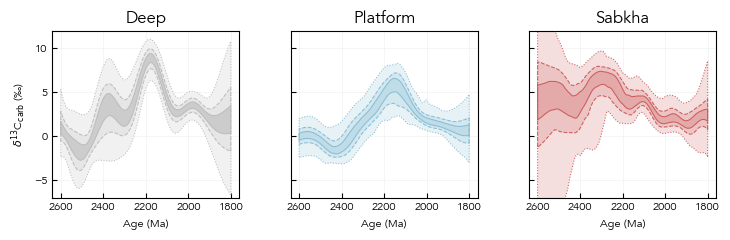

In [10]:
fs = 8 

mosaic = """
        012
        """
fig, ax = plt.subplot_mosaic(mosaic,  figsize = (7.5, 2.5), sharex = True, sharey = True) 


for key in list(ax.keys()):
    ax[key].tick_params(direction="in", labelsize=fs)
    ax[key].set_xlabel('Age (Ma)', fontsize = fs)
    
ax['0'].set_ylabel(r'$\delta^{13}$C$_{\mathrm{carb}}$ (‰)', fontsize = fs)

ax['1'].sharey(ax['0'])
ax['2'].sharey(ax['0'])
ax['1'].set_ylabel('')
ax['2'].set_ylabel('')

for key in '012':
    ax[key].set_axisbelow(True)
    ax[key].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle="solid", zorder=-1)

# deep-water d13C inference
ages = deep_trace.X_new.X_new.values
proxy_pred = az.extract(deep_trace.posterior_predictive)["f_pred_" + "d13c"].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax["0"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="white",
    edgecolor="none",
    alpha=1,
    lw=0,
    zorder=1,
)

ax["0"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="#BDBDBD",
    edgecolor="none",
    alpha=0.2,
    lw=0,
    zorder=2,
)

ax["0"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="dotted",
    edgecolor="#BDBDBD",
    alpha=1,
    lw=0.75,
    zorder=3,
)

hi = np.percentile(proxy_pred, 100 - 17, axis=1).flatten()

lo = np.percentile(proxy_pred, 17, axis=1).flatten()

ax["0"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="#BDBDBD",
    edgecolor="none",
    alpha=0.2, # 0.1
    lw=0,
    zorder=4,
)

ax["0"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="66% envelope",
    edgecolor="#BDBDBD",
    linestyle="dashed",
    alpha=1,
    lw=0.75,
    zorder=5,
)

hi = np.percentile(proxy_pred, 100 - 33.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 33.5, axis=1).flatten()

ax["0"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="gray",
    edgecolor="none",
    alpha=0.25,
    lw=0,
    zorder=6,
)

ax["0"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="33% envelope",
    edgecolor="#BDBDBD",
    alpha=1,
    lw=0.75,
    linestyle="solid",
    zorder=7,
)

# intermediate (platform) d13C inference
ages = sabkha_trace.X_new.X_new.values
proxy_pred = az.extract(platform_trace.posterior_predictive)["f_pred_" + "d13c"].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="white",
    edgecolor="none",
    alpha=1,
    lw=0,
    zorder=1,
)

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="#87BED5",
    edgecolor="none",
    alpha=0.2, 
    lw=0,
    zorder=2,
)

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="dotted",
    edgecolor="#87BED5",
    alpha=1,
    lw=0.75,
    zorder=3,
)

hi = np.percentile(proxy_pred, 100 - 17, axis=1).flatten()

lo = np.percentile(proxy_pred, 17, axis=1).flatten()

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="#87BED5",
    edgecolor="none",
    alpha=0.2, # 0.1
    lw=0,
    zorder=4,
)

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="66% envelope",
    edgecolor="#87BED5",
    linestyle="dashed",
    alpha=1,
    lw=0.75,
    zorder=5,
)

hi = np.percentile(proxy_pred, 100 - 33.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 33.5, axis=1).flatten()

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="#87BED5",
    edgecolor="none",
    alpha=0.25,
    lw=0,
    zorder=6,
)

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="33% envelope",
    edgecolor="#87BED5", 
    alpha=1,
    lw=0.75,
    linestyle="solid",
    zorder=7,
)

# sabkha d13C inference
ages = sabkha_trace.X_new.X_new.values
proxy_pred = az.extract(sabkha_trace.posterior_predictive)["f_pred_" + "d13c"].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="white",
    edgecolor="none",
    alpha=1,
    lw=0,
    zorder=1,
)

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="indianred",
    edgecolor="none",
    alpha=0.2, 
    lw=0,
    zorder=2,
)

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="dotted",
    edgecolor="indianred",
    alpha=1,
    lw=0.75,
    zorder=3,
)

hi = np.percentile(proxy_pred, 100 - 17, axis=1).flatten()

lo = np.percentile(proxy_pred, 17, axis=1).flatten()

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="indianred",
    edgecolor="none",
    alpha=0.2,
    lw=0,
    zorder=4,
)

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="66% envelope",
    edgecolor="indianred",
    linestyle="dashed",
    alpha=1,
    lw=0.75,
    zorder=5,
)

hi = np.percentile(proxy_pred, 100 - 33.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 33.5, axis=1).flatten()

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="indianred",
    edgecolor="none",
    alpha=0.25,
    lw=0,
    zorder=6,
)

ax["2"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="33% envelope",
    edgecolor="indianred", 
    alpha=1,
    lw=0.75,
    linestyle="solid",
    zorder=7,
)

yl = ax['2'].get_ylim()
ax['2'].set_ylim([-7, 12])

ax['0'].invert_xaxis()

ax['0'].set_title('Deep')
ax['1'].set_title('Platform')
ax['2'].set_title('Sabkha')

fig.tight_layout()
fig.subplots_adjust(wspace = 0.275, hspace = 0.8)


## Figure 3

In [34]:
# load the 'all-data' inference results
full_trace = stratmc.data.load_trace("traces/" + "paleoproterozoic_d13C_trace")

In [35]:
## compute posterior distribution of facies in 10 Myr bins

# 10 Myr age bins
x_bin_edges = full_trace.X_new.X_new.values[::10]

# environment bins
y_bin_edges = np.array([0, 1, 2, 3])

# initialize histogram with counts for first section 
section = include_sections[0]

section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]
include_idx = (~section_df['Exclude?'].values) & (~np.isnan(section_df['d13c'].values))

# grab posterior age models
posterior_sample_ages = az.extract(full_trace.posterior)[section + '_ages'].values

# facies (environment) data for current section
section_facies_temp = section_df['Depositional Environment'].values[include_idx]
section_facies_grid = np.tile(section_facies_temp.reshape(len(section_facies_temp), 1), (1, posterior_sample_ages.shape[1]))
     
# convert environment classifications (strings) to floats for 2D histogram
section_facies_grid_numeric = section_facies_grid.copy()
deep_idx = np.where(section_facies_temp == 'Lower ramp, slope, and deep basin')[0]
section_facies_grid_numeric[deep_idx, :] = 0.5

platform_idx = np.where(section_facies_temp == 'Platform and mid-upper ramp')[0]
section_facies_grid_numeric[platform_idx, :] = 1.5

sabkha_idx = np.where(section_facies_temp == 'Sabkha - peritidal')[0]
section_facies_grid_numeric[sabkha_idx, :] = 2.5

other_idx = np.where((section_facies_temp != 'Sabkha - peritidal') & (section_facies_temp != 'Platform and mid-upper ramp') & (section_facies_temp != 'Lower ramp, slope, and deep basin'))[0]
section_facies_grid_numeric[other_idx, :] = -100

section_facies_grid_numeric = section_facies_grid_numeric.astype(float) 

# 2D histogram (bins = ages and environments)
hist, x_edges, y_edges = np.histogram2d(posterior_sample_ages[include_idx, :].ravel(), section_facies_grid_numeric.ravel(), bins = [x_bin_edges, y_bin_edges])

# run same analysis on remaining sections, successively adding sample counts to histogram
for section in tqdm(include_sections[1:]):
    section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]
    include_idx = (~section_df['Exclude?'].values) & (~np.isnan(section_df['d13c'].values))

    section_facies_temp = section_df['Depositional Environment'].values[include_idx]
    posterior_sample_ages = az.extract(full_trace.posterior)[section + '_ages'].values

    section_facies_grid = np.tile(section_facies_temp.reshape(len(section_facies_temp), 1), (1, posterior_sample_ages.shape[1]))

    section_facies_grid_numeric = section_facies_grid.copy()
    deep_idx = np.where(section_facies_temp == 'Lower ramp, slope, and deep basin')[0]
    section_facies_grid_numeric[deep_idx, :] = 0.5

    platform_idx = np.where(section_facies_temp == 'Platform and mid-upper ramp')[0]
    section_facies_grid_numeric[platform_idx, :] = 1.5

    sabkha_idx = np.where(section_facies_temp == 'Sabkha - peritidal')[0]
    section_facies_grid_numeric[sabkha_idx, :] = 2.5

    other_idx = np.where((section_facies_temp != 'Sabkha - peritidal') & (section_facies_temp != 'Platform and mid-upper ramp') & (section_facies_temp != 'Lower ramp, slope, and deep basin'))[0]
    section_facies_grid_numeric[other_idx, :] = -100

    section_facies_grid_numeric = section_facies_grid_numeric.astype(float) 

    hist_temp, _, _ = np.histogram2d(posterior_sample_ages[include_idx, :].ravel(), section_facies_grid_numeric.ravel(), bins = [x_bin_edges, y_bin_edges])

    # add counts for current section to composite histogram
    hist += hist_temp

  0%|          | 0/75 [00:00<?, ?it/s]

In [36]:
# convert to percentages 
hist_percentages = hist.copy()

# columns = environments
hist_percentages[:, 0] = hist[:, 0]/np.sum(hist, axis = 1) # deep
hist_percentages[:, 1] = hist[:, 1]/np.sum(hist, axis = 1) # platform
hist_percentages[:, 2] = hist[:, 2]/np.sum(hist, axis = 1) # sabkha

hist_percentages = hist_percentages * 100

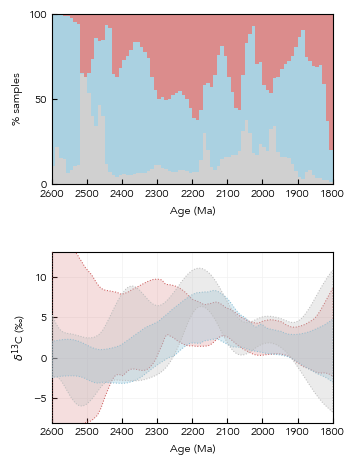

In [14]:
fs = 8
fig, ax = plt.subplots(2, 1, figsize = (3.65, 4.75), sharex = False, sharey = False)

ax[1].set_xlabel('Age (Ma)', fontsize = fs) 
ax[0].set_xlabel('Age (Ma)', fontsize = fs) 

ax[0].set_ylabel('% samples', fontsize = fs) 
ax[1].set_ylabel(r'$\delta^{13}$C (‰)', fontsize = fs)

ax[1].set_axisbelow(True)
ax[1].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle="solid", zorder=-1)

for axis in ax.ravel(): 
    axis.tick_params(labelsize = fs, direction = 'in') 

## Figure 3a: depositional environment over time 
# deep
bottom = np.zeros_like(hist_percentages[:, 0])
bars_1 = ax[0].bar(x_edges[:-1], hist_percentages[:, 0], width=np.diff(x_edges), color = '#BDBDBD', edgecolor="none", align="edge", bottom = bottom, lw = 0, alpha = 0.7)

# platform
bottom +=  hist_percentages[:, 0]
bars_2 = ax[0].bar(x_edges[:-1], hist_percentages[:, 1], width=np.diff(x_edges), color = '#87BED5', edgecolor="none", align="edge", bottom = bottom, lw = 0, alpha = 0.7)

# sabkha
bottom +=  hist_percentages[:, 1]
ax[0].bar(x_edges[:-1], hist_percentages[:, 2], width=np.diff(x_edges), color = 'indianred', edgecolor="none", align="edge", bottom = bottom, lw = 0, alpha = 0.7)
    
ax[0].set_ylim([0, 100])
ax[0].set_yticks([0, 50, 100])

## Figure 3B: within-environment d13C inferences
# sabkha
ages = sabkha_trace.X_new.X_new.values
proxy_pred = az.extract(sabkha_trace.posterior_predictive)["f_pred_" + "d13c"].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax[1].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="indianred",
    edgecolor="none",
    alpha=0.2, # 0.1
    lw=0,
    zorder=2,
)

ax[1].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="dotted",
    edgecolor="indianred",
    alpha=1,
    lw=0.75,
    zorder=3,
)

# platform 
ages = sabkha_trace.X_new.X_new.values
proxy_pred = az.extract(platform_trace.posterior_predictive)["f_pred_" + "d13c"].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax[1].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="#87BED5",
    edgecolor="none",
    alpha=0.3, # 0.1
    lw=0,
    zorder=4,
)

ax[1].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="dotted",
    edgecolor="#87BED5",
    alpha=1,
    lw=0.75,
    zorder=5,
)

# deep 
ages = deep_trace.X_new.X_new.values
proxy_pred = az.extract(deep_trace.posterior_predictive)["f_pred_" + "d13c"].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()


ax[1].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="#BDBDBD",
    edgecolor="none",
    alpha=0.3, # 0.1
    lw=0,
    zorder=6,
)

ax[1].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="dotted",
    edgecolor="#BDBDBD",
    alpha=1,
    lw=0.75,
    zorder=7,
)

ax[0].set_xlim([2600, 1800])
ax[1].set_xlim([2600, 1800])

ax[1].set_ylim([-8, 13])

fig.tight_layout()

plt.subplots_adjust(hspace = 0.4) 

file = 'Fig3'
fig.savefig(str("figures/"+ file +".pdf"), format="pdf", dpi = 500, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=0.2)

## Supplementary figures

### Posterior and prior distribution of depositional environments over time (Fig. S38)

In [41]:
## load prior age models (prior sample ages extracted and stored in dictionary, with section keys as names)
prior_sample_ages = stratmc.data.load_object('data/prior_sample_age_grid')

In [42]:
## prior distribution of environments over time in 10 Myr bins

# 10 Myr age bins
x_bin_edges = full_trace.X_new.X_new.values[::10]

# environment bins
y_bin_edges = np.array([0, 1, 2, 3])

# initialize histogram with counts for first section 
section = include_sections[0]

section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]
include_idx = (~section_df['Exclude?'].values) & (~np.isnan(section_df['d13c'].values))

# facies (environment) data for current section
section_facies_temp = section_df['Depositional Environment'].values[include_idx]

section_facies_grid = np.tile(section_facies_temp.reshape(len(section_facies_temp), 1), (1, prior_sample_ages[section].shape[1]))
     
# convert environment classifications (strings) to floats for 2D histogram
section_facies_grid_numeric = section_facies_grid.copy()
deep_idx = np.where(section_facies_temp == 'Lower ramp, slope, and deep basin')[0]
section_facies_grid_numeric[deep_idx, :] = 0.5

platform_idx = np.where(section_facies_temp == 'Platform and mid-upper ramp')[0]
section_facies_grid_numeric[platform_idx, :] = 1.5

sabkha_idx = np.where(section_facies_temp == 'Sabkha - peritidal')[0]
section_facies_grid_numeric[sabkha_idx, :] = 2.5

other_idx = np.where((section_facies_temp != 'Sabkha - peritidal') & (section_facies_temp != 'Platform and mid-upper ramp') & (section_facies_temp != 'Lower ramp, slope, and deep basin'))[0]
section_facies_grid_numeric[other_idx, :] = -100

section_facies_grid_numeric = section_facies_grid_numeric.astype(float) 

# 2D histogram (bins = ages and environments)
hist_prior, x_edges, y_edges = np.histogram2d(prior_sample_ages[section][include_idx, :].ravel(), section_facies_grid_numeric.ravel(), bins = [x_bin_edges, y_bin_edges])

# run same analysis on remaining sections, successively adding sample counts to histogram
for section in tqdm(include_sections[1:]):
    section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]
    include_idx = (~section_df['Exclude?'].values) & (~np.isnan(section_df['d13c'].values))

    section_facies_temp = section_df['Depositional Environment'].values[include_idx]

    section_facies_grid = np.tile(section_facies_temp.reshape(len(section_facies_temp), 1), (1, prior_sample_ages[section].shape[1]))

    section_facies_grid_numeric = section_facies_grid.copy()
    deep_idx = np.where(section_facies_temp == 'Lower ramp, slope, and deep basin')[0]
    section_facies_grid_numeric[deep_idx, :] = 0.5

    platform_idx = np.where(section_facies_temp == 'Platform and mid-upper ramp')[0]
    section_facies_grid_numeric[platform_idx, :] = 1.5

    sabkha_idx = np.where(section_facies_temp == 'Sabkha - peritidal')[0]
    section_facies_grid_numeric[sabkha_idx, :] = 2.5

    other_idx = np.where((section_facies_temp != 'Sabkha - peritidal') & (section_facies_temp != 'Platform and mid-upper ramp') & (section_facies_temp != 'Lower ramp, slope, and deep basin'))[0]
    section_facies_grid_numeric[other_idx, :] = -100

    section_facies_grid_numeric = section_facies_grid_numeric.astype(float) 

    hist_temp, _, _ = np.histogram2d(prior_sample_ages[section][include_idx, :].ravel(), section_facies_grid_numeric.ravel(), bins = [x_bin_edges, y_bin_edges])

    # add counts for current section to composite histogram
    hist_prior += hist_temp

  0%|          | 0/75 [00:00<?, ?it/s]

In [43]:
# convert to percentages
hist_percentages_prior = hist_prior.copy()

# columns = environments
hist_percentages_prior[:, 0] = hist_prior[:, 0]/np.sum(hist_prior, axis = 1) # deep
hist_percentages_prior[:, 1] = hist_prior[:, 1]/np.sum(hist_prior, axis = 1) # platform
hist_percentages_prior[:, 2] = hist_prior[:, 2]/np.sum(hist_prior, axis = 1) # sabkha
    
hist_percentages_prior = hist_percentages_prior * 100

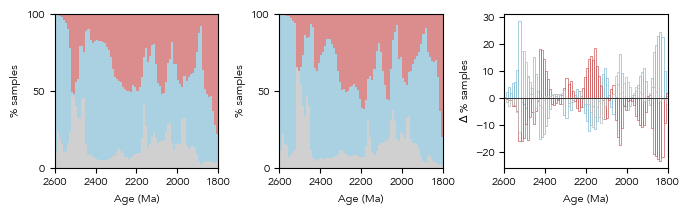

In [18]:
fs = 8 

mosaic = """
    012
    """
fig, ax = plt.subplot_mosaic(mosaic,  figsize = (7, 2.25), sharex = True, sharey = False)

for key in '1':
    ax[key].sharey(ax['0'])

# prior facies over time
bottom = np.zeros_like(hist_percentages_prior[:, 0])
bars_1 = ax['0'].bar(x_edges[:-1], hist_percentages_prior[:, 0], width=np.diff(x_edges), color = '#BDBDBD', edgecolor="none", align="edge", bottom = bottom, lw = 0, alpha = 0.7)
bottom +=  hist_percentages_prior[:, 0]
bars_2 = ax['0'].bar(x_edges[:-1], hist_percentages_prior[:, 1], width=np.diff(x_edges), color = '#87BED5', edgecolor="none", align="edge", bottom = bottom, lw = 0, alpha = 0.7)

bottom +=  hist_percentages_prior[:, 1]
ax['0'].bar(x_edges[:-1], hist_percentages_prior[:, 2], width=np.diff(x_edges), color = 'indianred', edgecolor="none", align="edge", bottom = bottom, lw = 0, alpha = 0.7)
    
# posterior facies over time
bottom = np.zeros_like(hist_percentages[:, 0])
bars_1 = ax['1'].bar(x_edges[:-1], hist_percentages[:, 0], width=np.diff(x_edges), color = '#BDBDBD', edgecolor="none", align="edge", bottom = bottom, lw = 0, alpha = 0.7)
bottom +=  hist_percentages[:, 0]
bars_2 = ax['1'].bar(x_edges[:-1], hist_percentages[:, 1], width=np.diff(x_edges), color = '#87BED5', edgecolor="none", align="edge", bottom = bottom, lw = 0, alpha = 0.7)
bottom +=  hist_percentages[:, 1]
ax['1'].bar(x_edges[:-1], hist_percentages[:, 2], width=np.diff(x_edges), color = 'indianred', edgecolor="none", align="edge", bottom = bottom, lw = 0, alpha = 0.7)
    
ax['0'].invert_xaxis()
ax['0'].set_xlim([2600, 1800])
ax['0'].set_ylim([0, 100])
ax['0'].set_yticks([0, 50, 100])
ax['0'].set_ylabel('% samples', fontsize = fs)
ax['1'].set_ylabel('% samples', fontsize = fs)

# difference between prior and posterior
bottom = np.zeros_like(hist_percentages_prior[:, 0])
ax['2'].bar(x_edges[:-1], hist_percentages[:, 1] - hist_percentages_prior[:, 1], width=np.diff(x_edges), color = 'none', edgecolor="#87BED5", align="edge", bottom = bottom, lw = 0.5)

ax['2'].bar(x_edges[:-1], hist_percentages[:, 2] - hist_percentages_prior[:, 2], width=np.diff(x_edges), color = 'none', edgecolor="indianred", align="edge", bottom = bottom, lw = 0.5)

ax['2'].bar(x_edges[:-1], hist_percentages[:, 0] - hist_percentages_prior[:, 0], width=np.diff(x_edges), color = 'none', edgecolor="#BDBDBD", align="edge", bottom = bottom, lw = 0.5)
ax['2'].axhline(0, color = 'k', lw = 0.5)

ax['2'].set_ylabel(r'$\Delta$ % samples', fontsize = fs, labelpad = 1) # (posterior - prior)


for key in '012': 
    ax[key].tick_params(labelsize = fs)
    ax[key].set_xlabel('Age (Ma)', fontsize = fs) 

    
fig.tight_layout()
plt.subplots_adjust(wspace = 0.375)

file = 'FigS38'
fig.savefig(str("figures/"+ file +".pdf"), format="pdf", dpi = 500, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=0.2)


### Residuals between d13C observations and within-environment d13C signal inferences (Fig. S39)

#### Compute residuals

In [19]:
# compute residuals for each section 
d13C_pred = az.extract(full_trace.posterior_predictive)['f_pred_d13c'].values
ages_pred = full_trace.X_new.X_new.values 

d13C_residuals = {}
draws = d13C_pred.shape[1]

sample_ages = {} 

# compute residuals for each section and posterior draw
for section in tqdm(include_sections): 
    section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]
    keep_idx = np.where((~section_df['Exclude?']) & ~(np.isnan(section_df['d13c'])))[0]
    
    section_d13C = section_df['d13c'].values[keep_idx]
        
    sample_ages[section] = az.extract(full_trace.posterior)[section + '_ages'].values[keep_idx, :]
    
    # interpolate the d13C signal inference to the sample ages for each draw
    d13C_interp = np.ones_like(sample_ages[section]) * np.nan 
    
    for i in range(draws): 
        d13C_interp[:, i] = np.interp(sample_ages[section][:, i], ages_pred, d13C_pred[:, i])
        
    d13C_residuals[section] = np.repeat(section_d13C.reshape(1, section_d13C.shape[0]), draws, axis = 0).T - d13C_interp
    

  0%|          | 0/76 [00:00<?, ?it/s]

In [20]:
# sort computed residuals by depositional environment (using 10 Myr sliding window)
ages_new = full_trace.X_new.X_new.values

deep_residuals_binned = {}
sabkha_residuals_binned = {}
platform_residuals_binned = {}

section_facies_grid = {} 

# 10 Myr sliding window
window_size = 10

# total number of draws
n_draws = len(full_trace.posterior.chain.values) * len(full_trace.posterior.draw.values) 

# initialize a list for each age (at center of sliding window) 
for age in ages_new: 
    deep_residuals_binned[age] = [] 
    sabkha_residuals_binned[age] = [] 
    platform_residuals_binned[age] = [] 
    
for section in tqdm(include_sections): 
    # depositional environment for current section
    section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]
    section_facies_temp = section_df['Depositional Environment'].values[keep_idx]
    section_facies_grid[section] = np.tile(section_facies_temp.reshape(len(section_facies_temp), 1), (1, n_draws))
    
    # for each age, concatenate the residuals (by environment) within 10 Myr window
    for i, age in enumerate(ages_new):
        deep_cond = section_facies_grid[section] == 'Lower ramp, slope, and deep basin'
        sabkha_cond = section_facies_grid[section] == 'Sabkha - peritidal'
        platform_cond = section_facies_grid[section] == 'Platform and mid-upper ramp'

        # mask sample ages with sliding 10 Myr window
        age_mask = (sample_ages[section] <= age + (window_size/2)) & (sample_ages[section] >= age - (window_size/2))

        # concatenate residuals for each environment that fall within the current age window
        deep_residuals_binned[age] += list(d13C_residuals[section][deep_cond & age_mask].ravel())
        platform_residuals_binned[age] += list(d13C_residuals[section][platform_cond & age_mask].ravel())
        sabkha_residuals_binned[age] += list(d13C_residuals[section][sabkha_cond & age_mask].ravel())
        

  0%|          | 0/76 [00:00<?, ?it/s]

#### Compute probability envelopes for plotting

In [21]:
# compute 1-sigma (66%) probability envelope for each age bin center (iterating in loop due to dictionary/list format)
deep_residuals_17 = [] 
deep_residuals_83 = [] 

platform_residuals_17 = [] 
platform_residuals_83 = [] 

sabkha_residuals_17 = [] 
sabkha_residuals_83 = [] 

all_residuals_17 = [] 
all_residuals_83 = [] 

ages_new = full_trace.X_new.X_new.values

for age in tqdm(ages_new): 
    deep_residuals_17 += [np.nanpercentile(deep_residuals_binned[age], 17)]
    deep_residuals_83 += [np.nanpercentile(deep_residuals_binned[age], 83)]
        
    sabkha_residuals_17 += [np.nanpercentile(sabkha_residuals_binned[age], 17)]
    sabkha_residuals_83 += [np.nanpercentile(sabkha_residuals_binned[age], 83)]
    
    platform_residuals_17 += [np.nanpercentile(platform_residuals_binned[age], 17)]
    platform_residuals_83 += [np.nanpercentile(platform_residuals_binned[age], 83)]
    

  0%|          | 0/801 [00:00<?, ?it/s]

#### Plot results

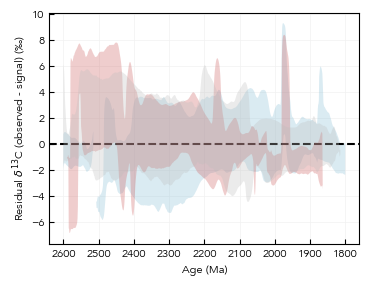

In [22]:
fig = plt.figure(figsize = (4, 3))
ax = fig.gca() 

fs = 8

ax.fill_between(ages_new, 
                sabkha_residuals_83, 
                sabkha_residuals_17, 
                color="indianred", # #8fbc8f
                label='66% envelope',
                linestyle = 'solid',
                edgecolor = 'none',
                alpha = 0.3, 
                lw = 0.75,
                zorder = 2)

ax.fill_between(ages_new, 
                   platform_residuals_83, 
                   platform_residuals_17, 
                   color='#87BED5',
                    label='66% envelope',
                     alpha = 0.3,
                    lw = 0,
                    zorder = 1)


ax.fill_between(ages_new, deep_residuals_83, deep_residuals_17, color='#BDBDBD',
                        label= '66% envelope',
                        linestyle = 'solid',
                        edgecolor = 'none',
                         alpha = 0.3,
                        lw = 0.75,
                        zorder = 2)

    
ax.set_ylabel(r'Residual $\delta^{13}$C (observed - signal) (‰)', fontsize = fs, labelpad = 1) #  (observed - signal)

ax.axhline(0, linestyle = 'dashed', color = 'k', lw = 1.5, zorder = 1)

ax.tick_params(direction="in", labelsize=fs)
ax.set_xlabel('Age (Ma)', fontsize = fs)
    
ax.set_axisbelow(True)
ax.grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle="solid", zorder=-1)

ax.invert_xaxis()

file = 'FigS39'
fig.savefig(str("figures/"+ file +".pdf"), format="pdf", dpi = 500, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=0.2)
